In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# veride okunamayan karakterleri okutmak için encoding
df = pd.read_csv(r"C:\Users\ASUS\Desktop\Bitirme\1-data_cleaning\clean_data.csv") 

df.head(4)

,price,m2,age,floor,district,neighbor,total_room
0,2229999,110,0,1.0,Beylikdüzü,Marmara Mah.,3
1,2650000,90,0,4.0,Esenyurt,Güzelyurt Mah.,2
2,3449999,130,0,2.0,Beylikdüzü,Adnan Kahveci Mah.,3
3,5475000,125,21,4.0,Pendik,Harmandere Mah.,3


# Encoding Yöntemleri
### 1. Label Encoding
Her benzersiz kategoriyi bir tamsayıya çevirir.

Örn: ['Beşiktaş', 'Kadıköy', 'Üsküdar'] → [0, 1, 2]

Avantajı: Basit ve hızlıdır.

Dezavantajı: Sayılar sıralıymış gibi algılanabilir (model için yanıltıcı olabilir).

Kullanım Durumu: Ağaç tabanlı modellerde (RandomForest, XGBoost vs.) sıklıkla güvenle kullanılır.

### 2. One-Hot Encoding
Her kategori için ayrı bir sütun açar ve 0/1 ile temsil eder.

Avantajı: Kategoriler arasında yapay sıralama ilişkisi kurulmaz.

Dezavantajı: Yüksek kardinalite (kategori sayısı çok fazla) durumunda boyut patlamasına neden olabilir.

Kullanım Durumu: Linear Regression, Logistic Regression gibi lineer modellerde güvenlidir.

### 3. Target Encoding (Mean Encoding)
Her kategori, hedef değişkenin (örneğin price) ortalaması ile temsil edilir.

Avantajı: Bilgi açısından zengin, performansı artırabilir.

Dezavantajı: Overfitting riski yüksektir, dikkatli çapraz doğrulama gerekir.

Kullanım Durumu: Genelde Kaggle yarışmalarında sıkça tercih edilir, dikkatli uygulanmalı.

### 4. Frequency Encoding
Her kategori, veri setindeki frekansıyla (kaç kez geçtiği) temsil edilir.

Avantajı: Kolay uygulanır, overfitting riski düşüktür.

Dezavantajı: Anlamı doğrudan hedefle ilgili değildir.

Kullanım Durumu: Basit ama etkili bir yöntem, baseline olarak kullanılabilir.

### 5. Binary Encoding
Kategoriler önce label encoding’e, sonra ikili (binary) sayıya dönüştürülür.

Avantajı: Yüksek kardinaliteyi daha verimli işler.

Dezavantajı: Yorumu zordur.

Kullanım Durumu: One-hot encoding’in dezavantajlarını aşmak istediğinde tercih edilebilir.



# Karşılaştırma

Model Performansı: R² Score, RMSE, MAE gibi regresyon metrikleriyle model başarısını ölç.

Zaman: Encoding ve model eğitim süresini ölç.

Boyut: Encoding sonrası oluşan veri setinin sütun sayısı.

Overfitting Riski: Eğitim/Doğrulama farkı büyükse yüksek overfitting vardır (Target Encoding’de dikkat).

Kardinalite Duyarlılığı: Mahalle gibi çok fazla kategori varsa, bazı encodingler sorun yaratabilir. (OHE encoding)


In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

categorical_cols = ['district', 'neighbor']
target_col = 'price'
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target_col] #price kolonunu ayrı tutmak için

results = {}

def evaluate_model(df_encoded):
    X = df_encoded.drop(columns=[target_col])
    y = df_encoded[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return {
        'R2': r2_score(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'RMSE': np.sqrt(mean_squared_error(y_test, preds)),
        'Feature_Count': X.shape[1]
    }

# 1. Label Encoding
le_df = df.copy()
for col in categorical_cols:
    le_df[col + '_encoded'] = le_df[col].astype('category').cat.codes
le_result = le_df[numerical_cols + [col + '_encoded' for col in categorical_cols] + [target_col]]
results['Label Encoding'] = evaluate_model(le_result)

# 2. One-Hot Encoding
ohe_df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
ohe_result = ohe_df[numerical_cols + [col for col in ohe_df.columns if col not in df.columns or col == target_col]]
results['One-Hot Encoding'] = evaluate_model(ohe_result)

# 3. Ordinal Encoding (alfabetik sıralı)
oe_df = df.copy()
for col in categorical_cols:
    unique_vals = sorted(df[col].unique())
    ordinal_map = {val: idx for idx, val in enumerate(unique_vals)}
    oe_df[col + '_encoded'] = df[col].map(ordinal_map)
oe_result = oe_df[numerical_cols + [col + '_encoded' for col in categorical_cols] + [target_col]]
results['Ordinal Encoding'] = evaluate_model(oe_result)

# 4. Target Encoding
te_df = df.copy()
for col in categorical_cols:
    mean_encoded = df.groupby(col)[target_col].mean()
    te_df[col + '_encoded'] = df[col].map(mean_encoded)
te_result = te_df[numerical_cols + [col + '_encoded' for col in categorical_cols] + [target_col]]
results['Target Encoding'] = evaluate_model(te_result)

# 5. Frequency Encoding
fe_df = df.copy()
for col in categorical_cols:
    freq_encoded = df[col].value_counts(normalize=True)
    fe_df[col + '_encoded'] = df[col].map(freq_encoded)
fe_result = fe_df[numerical_cols + [col + '_encoded' for col in categorical_cols] + [target_col]]
results['Frequency Encoding'] = evaluate_model(fe_result)

results_df = pd.DataFrame(results).T
print(results_df)


                          R2           MAE          RMSE  Feature_Count
Label Encoding      0.770824  2.140222e+06  4.000766e+06            6.0
One-Hot Encoding    0.800766  1.922723e+06  3.730268e+06          612.0
Ordinal Encoding    0.770824  2.140222e+06  4.000766e+06            6.0
Target Encoding     0.829256  1.818105e+06  3.453274e+06            6.0
Frequency Encoding  0.763681  2.133829e+06  4.062638e+06            6.0


R² (R-kare): Modelin veri üzerindeki açıklama gücünü ölçer. 1'e ne kadar yakınsa, model o kadar iyi açıklama yapıyor demektir.

MAE (Mean Absolute Error): Ortalama mutlak hata. Modelin tahminleriyle gerçek değerler arasındaki ortalama mutlak farkı gösterir. Düşük olması daha iyidir.

RMSE (Root Mean Squared Error): Ortalama kare hatanın kareköküdür. Hataları daha ağır cezalandırır (aşırı tahminleri öne çıkarır). Düşük olması istenir.

Feature_Count: Kodlama sonrasında oluşan öznitelik (sütun) sayısı.



*En iyi performans:*
Target Encoding hem doğruluk (R² = 0.829) açısından en iyi sonucu veriyor hem de hata oranları (MAE = 1.818M, RMSE = 3.453M) en düşük. Ayrıca sadece 6 özellik ile çalışıyor, bu da modelin daha sade olduğunu gösteriyor.

One-Hot Encoding:
İyi performans (R² = 0.801) gösterse de, çok fazla öznitelik (612) oluşturduğu için yüksek boyutluluk (curse of dimensionality) sorunu yaratabilir. Bellek ve işlem maliyeti artar.

Label ve Ordinal Encoding:
Bunlar aynı sonucu veriyor (R² = 0.771), çünkü muhtemelen kategorik sıralamanın model için anlamı yok. Basit ama etkisiz olabilir.

Frequency Encoding:
Performansı en düşük olan yöntem. R² en düşük ve RMSE en yüksek. Bu yöntemin kategorik bilgileri iyi temsil etmediği anlaşılıyor.

# Görselleştirme


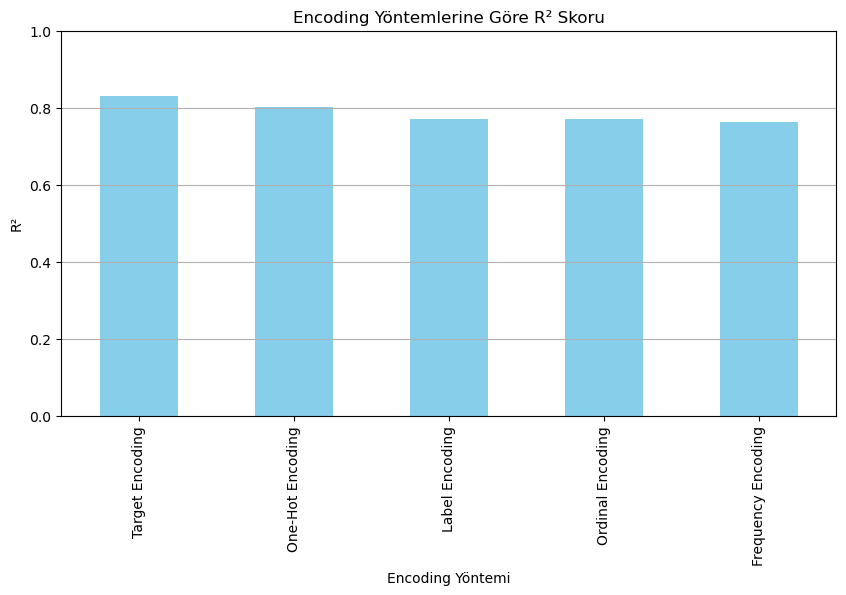

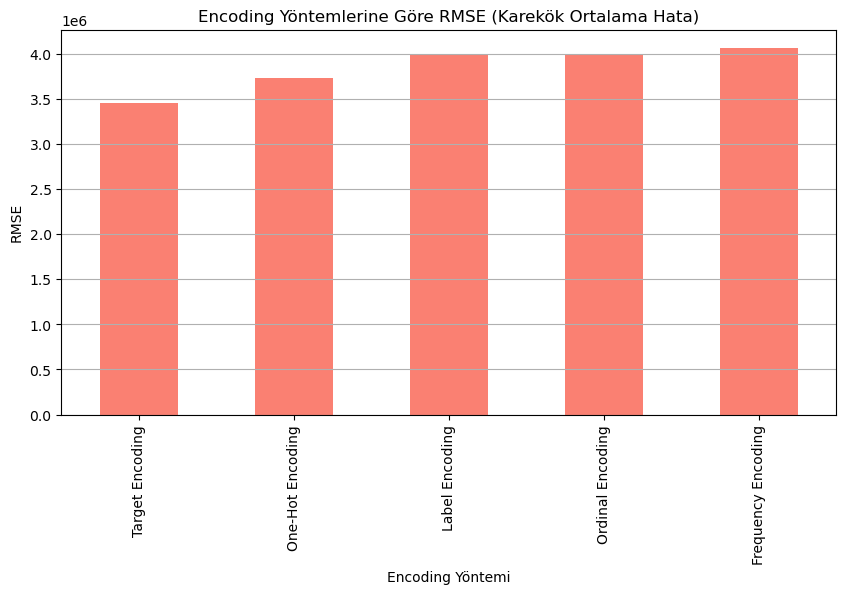

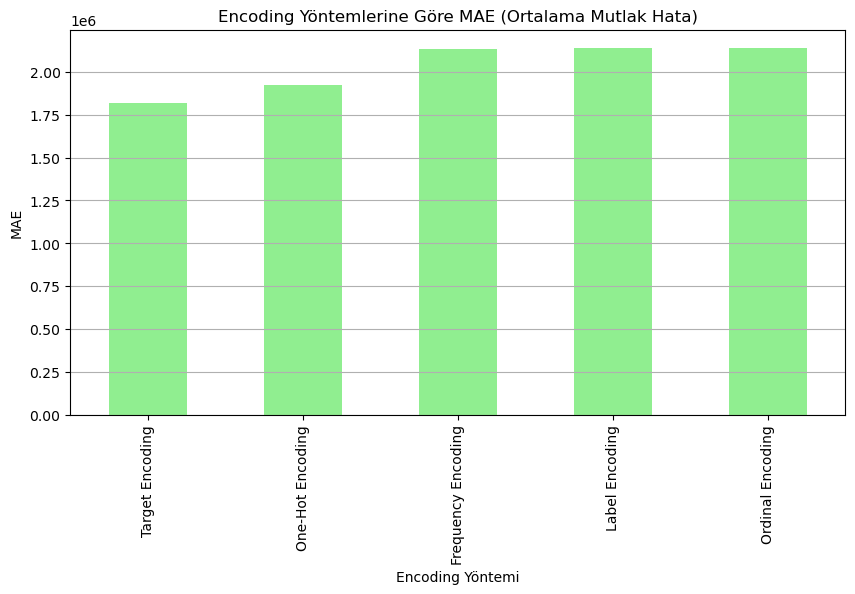

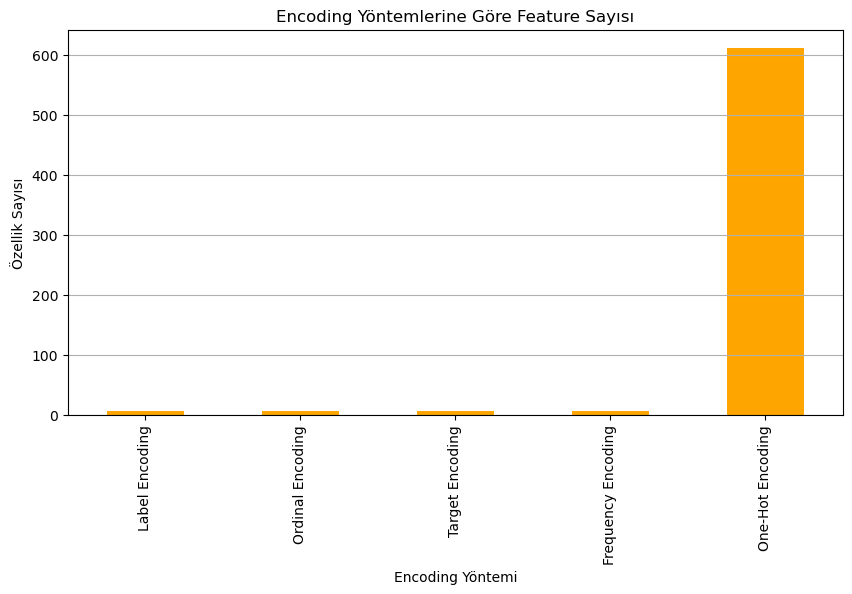

In [51]:
import matplotlib.pyplot as plt

# R2 skorlarını çiz
plt.figure(figsize=(10, 5))
results_df['R2'].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Encoding Yöntemlerine Göre R² Skoru')
plt.ylabel('R²')
plt.xlabel('Encoding Yöntemi')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# RMSE değerlerini çiz
plt.figure(figsize=(10, 5))
results_df['RMSE'].sort_values().plot(kind='bar', color='salmon')
plt.title('Encoding Yöntemlerine Göre RMSE (Karekök Ortalama Hata)')
plt.ylabel('RMSE')
plt.xlabel('Encoding Yöntemi')
plt.grid(axis='y')
plt.show()

# MAE değerlerini çiz
plt.figure(figsize=(10, 5))
results_df['MAE'].sort_values().plot(kind='bar', color='lightgreen')
plt.title('Encoding Yöntemlerine Göre MAE (Ortalama Mutlak Hata)')
plt.ylabel('MAE')
plt.xlabel('Encoding Yöntemi')
plt.grid(axis='y')
plt.show()

# Özellik sayısını çiz
plt.figure(figsize=(10, 5))
results_df['Feature_Count'].sort_values().plot(kind='bar', color='orange')
plt.title('Encoding Yöntemlerine Göre Feature Sayısı')
plt.ylabel('Özellik Sayısı')
plt.xlabel('Encoding Yöntemi')
plt.grid(axis='y')
plt.show()


In [57]:
# district için target encoding (price'a göre)
district_mean_price = df.groupby('district')['price'].mean()
df['district_encoded'] = df['district'].map(district_mean_price)

# neighbor için target encoding (price'a göre)
neighbor_mean_price = df.groupby('neighbor')['price'].mean()
df['neighbor_encoded'] = df['neighbor'].map(neighbor_mean_price)

df = df.drop(columns=["district", "neighbor"])

df.head()

,price,m2,age,floor,total_room,district_encoded,neighbor_encoded
0,2229999,110,0,1.0,3,4.970296e+06,6.487466e+06
1,2650000,90,0,4.0,2,2.769582e+06,2.487815e+06
2,3449999,130,0,2.0,3,4.970296e+06,6.057293e+06
3,5475000,125,21,4.0,3,5.848908e+06,7.428125e+06
4,3450980,110,0,1.0,2,4.970296e+06,6.057293e+06


In [59]:
df.to_csv("encoded_data.csv", index=False)
print("encoded_data.csv kaydedildi!")

encoded_data.csv kaydedildi!
